In [1]:
!pip install pyspark
! apt remove -y openjdk-11-jre-headless
! apt install -y openjdk-8-jdk openjdk-8-jre

     |████████████████████████████████| 212.3 MB 13 kB/s s eta 0:00:01   |██▏                             | 14.7 MB 6.3 MB/s eta 0:00:32     |█████▋                          | 37.5 MB 11.9 MB/s eta 0:00:15     |████████████▍                   | 82.0 MB 20.6 MB/s eta 0:00:07     |█████████████▌                  | 89.9 MB 23.0 MB/s eta 0:00:06     |█████████████████               | 112.8 MB 17.2 MB/s eta 0:00:06     |███████████████████▌            | 129.1 MB 12.9 MB/s eta 0:00:07     |███████████████████▉            | 131.9 MB 12.9 MB/s eta 0:00:07     |█████████████████████████       | 166.2 MB 15.4 MB/s eta 0:00:03
     |████████████████████████████████| 198 kB 53.3 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=b3198ed5ea15e7d3be6db2adc44eba62d6507c3094f603c6ee993c3776f4ff69
  Stored in directory: /root/.cache/pip/wheels/fd/d2/1d/661fd740706117c29372aee63035c4048c27b5ae26690e7504
Successfully built pyspark
Reading packa

In [2]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

sc= SparkContext(master= 'local', appName= 'Fake and real news')
ss= SparkSession(sc)

In [3]:
from pyspark.sql.types import StringType, StructField, StructType
def read_data(path):
  schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])
  pd_df= pd.read_csv(path)
  sp_df= ss.createDataFrame(pd_df, schema= schema)
  return sp_df

In [4]:
path_true= '/kaggle/input/fake-and-real-news-dataset/True.csv'
path_fake= '/kaggle/input/fake-and-real-news-dataset/Fake.csv'
true_df= read_data(path_true)
fake_df= read_data(path_fake)

In [5]:
true_df.count()

21417

In [6]:
fake_df.count()

23481

In [7]:
from pyspark.sql.functions import lit, rand
data= true_df.withColumn('fake', lit(0)).union(fake_df.withColumn('fake', lit(1))).orderBy(rand())

In [8]:
data.groupBy('fake').count().show()

+----+-----+
|fake|count|
+----+-----+
|   1|23481|
|   0|21417|
+----+-----+



In [9]:
# Check the values of the subject column
data.select('subject').distinct().show()

+---------------+
|        subject|
+---------------+
|        US_News|
|      left-news|
|      worldnews|
|       politics|
|   politicsNews|
|Government News|
|    Middle-east|
|           News|
+---------------+



In [10]:
data.show(5)

+--------------------+--------------------+------------+-----------------+----+
|               title|                text|     subject|             date|fake|
+--------------------+--------------------+------------+-----------------+----+
| Trump LIVID Afte...|It was just a few...|        News|November 29, 2016|   1|
|BOOM! TREY GOWDY ...|Trey Gowdy asked ...|   left-news|     May 23, 2017|   1|
|Astroturfing: Jou...|Vic Bishop Waking...|     US_News| January 19, 2016|   1|
|EMBARRASSING: Oba...|President Barack ...|   left-news|      Dec 7, 2016|   1|
|Abe hopes to avoi...|(Reuters) - With ...|politicsNews|February 9, 2017 |   0|
+--------------------+--------------------+------------+-----------------+----+
only showing top 5 rows



In [11]:
from pyspark.ml.feature import SQLTransformer, RegexTokenizer, StopWordsRemover, CountVectorizer, Imputer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
StopWordsRemover.loadDefaultStopWords('english')

# 0. Extract tokens from title
title_tokenizer= RegexTokenizer(inputCol= 'title', outputCol= 'title_words',
                                pattern= '\\W', toLowercase= True)
# 1. Remove stop words from title
title_sw_remover= StopWordsRemover(inputCol= 'title_words', outputCol= 'title_sw_removed')
# 2. Compute Term frequency from title
title_count_vectorizer= CountVectorizer(inputCol= 'title_sw_removed', outputCol= 'tf_title')
# 3. Compute Term frequency-inverse document frequency from title
title_tfidf= IDF(inputCol= 'tf_title', outputCol= 'tf_idf_title')
# 4. Extract tokens from text
text_tokenizer= RegexTokenizer(inputCol= 'text', outputCol= 'text_words',
                                pattern= '\\W', toLowercase= True)
# 5. Remove stop words from text
text_sw_remover= StopWordsRemover(inputCol= 'text_words', outputCol= 'text_sw_removed')
# 6. Compute Term frequency from text
text_count_vectorizer= CountVectorizer(inputCol= 'text_sw_removed', outputCol= 'tf_text')
# 7. Compute Term frequency-inverse document frequency text
text_tfidf= IDF(inputCol= 'tf_text', outputCol= 'tf_idf_text')
# 8. StringIndexer subject
subject_str_indexer= StringIndexer(inputCol= 'subject', outputCol= 'subject_idx')
# 9. VectorAssembler
vec_assembler= VectorAssembler(inputCols=['tf_idf_title', 'tf_idf_text', 'subject_idx'], outputCol= 'features')

In [12]:
from pyspark.ml.classification import RandomForestClassifier
rf= RandomForestClassifier(featuresCol= 'features', labelCol= 'fake', predictionCol= 'fake_predict', maxDepth= 7, numTrees= 20)

In [13]:
from pyspark.ml import Pipeline
rf_pipe= Pipeline(stages=[title_tokenizer, # 0
                title_sw_remover, # 1
                title_count_vectorizer, # 2
                title_tfidf, # 3
                text_tokenizer, # 4
                text_sw_remover, # 5
                text_count_vectorizer, # 6
                text_tfidf, # 7
                subject_str_indexer, # 8
                vec_assembler, # 9
                rf]) # 10 model

In [14]:
train, test= data.randomSplit([0.8, 0.2])

In [15]:
rf_model= rf_pipe.fit(train)

In [16]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'fake', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'fake_predict', col2= 'fake').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

In [17]:
# Predict on training data set
rf_train_result= rf_model.transform(train)

In [18]:
classification_evaluator(rf_train_result)

+-----------------+-----+-----+
|fake_predict_fake|    0|    1|
+-----------------+-----+-----+
|              1.0| 1106|18069|
|              0.0|15924|  736|
+-----------------+-----+-----+

accuracy: 0.9485977396400167
f1: 0.9485658569272747
areaUnderROC: 0.9895893166305042


In [19]:
# Predict on test data set
rf_test_result= rf_model.transform(test)

In [20]:
classification_evaluator(rf_test_result)

+-----------------+----+----+
|fake_predict_fake|   0|   1|
+-----------------+----+----+
|              1.0| 322|4485|
|              0.0|4065| 191|
+-----------------+----+----+

accuracy: 0.9433962264150944
f1: 0.9433582288552546
areaUnderROC: 0.9879372779401323


In [21]:
lrModel = rf_model.stages[10]
trainingSummary = lrModel.summary

In [22]:
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.002020739165115661|
|0.0|0.004094655676681733|
|0.0|0.005902685455995746|
|0.0|0.007710715235309758|
+---+--------------------+
only showing top 5 rows

areaUnderROC: 0.9895924220251642


In [23]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

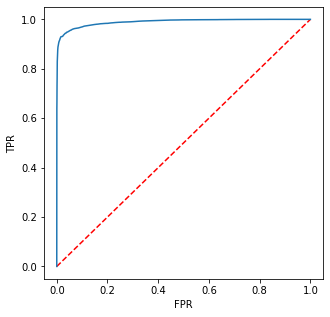

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_train = rf_model.transform(train)

y_true = predictions_train.select(['fake']).collect()
y_pred = predictions_train.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 0.9558223289315726, 'recall': 0.9350557839107457, 'f1-score': 0.9453250222617986, 'support': 17030}, '1': {'precision': 0.9423207301173403, 'recall': 0.9608614730124967, 'f1-score': 0.9515007898894154, 'support': 18805}, 'accuracy': 0.9485977396400167, 'macro avg': {'precision': 0.9490715295244565, 'recall': 0.9479586284616213, 'f1-score': 0.948412906075607, 'support': 35835}, 'weighted avg': {'precision': 0.9487371450135695, 'recall': 0.9485977396400167, 'f1-score': 0.9485658569272747, 'support': 35835}}


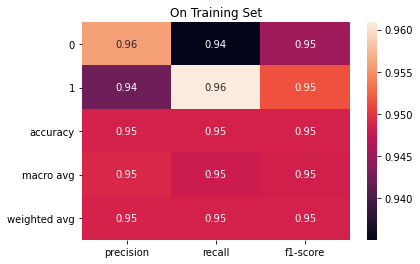

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Training Set')
plt.show()

In [32]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_test = rf_model.transform(test)

y_true = predictions_test.select(['fake']).collect()
y_pred = predictions_test.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 0.9551221804511278, 'recall': 0.9266013220879873, 'f1-score': 0.9406456091634849, 'support': 4387}, '1': {'precision': 0.9330143540669856, 'recall': 0.9591531223267751, 'f1-score': 0.9459031951913951, 'support': 4676}, 'accuracy': 0.9433962264150944, 'macro avg': {'precision': 0.9440682672590568, 'recall': 0.9428772222073811, 'f1-score': 0.94327440217744, 'support': 9063}, 'weighted avg': {'precision': 0.9437157812265612, 'recall': 0.9433962264150944, 'f1-score': 0.9433582288552546, 'support': 9063}}


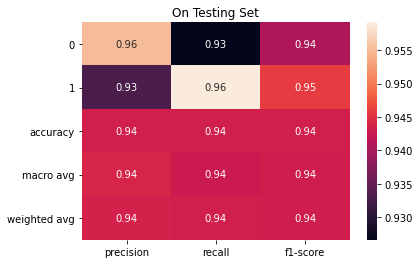

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Testing Set')
plt.show()

In [34]:
class_temp = rf_test_result.select("fake").groupBy("fake")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["fake"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

In [47]:
from sklearn.metrics import confusion_matrix
y_true = rf_test_result.select("fake")
y_true = y_true.toPandas()

y_pred = rf_test_result.select("fake_predict")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[4065,  322],
       [ 191, 4485]])

Confusion matrix, without normalization
[[4065  322]
 [ 191 4485]]


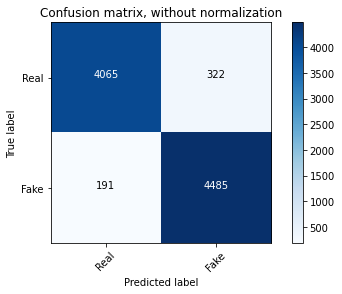

In [48]:
import matplotlib.pyplot as plt
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Real', 'Fake'],
                      title='Confusion matrix, without normalization')
plt.show()